<h1>Chapter 5 | Data Exercise #1 | Financial Assets | Generalizing from Data</h1>
<h2>Introduction:</h2>
<p>In this notebook, you will find my notes and code for Chapter 5's <b>exercise 1</b> of the book <a href="https://gabors-data-analysis.com/">Data Analysis for Business, Economics, and Policy</a>, by Gábor Békés and Gábor Kézdi. The question was: 
<p>1. Download ten years of daily data on the price of a financial asset, such as an individual stock, or another stock market index.</p>
<p>Assignments:</p>
<ul>
    <li>Document the main features of the data.</li>
    <li>Create daily percentage returns.</li>
    <li>Create a binary variable indicating large losses by choosing your own cutoff.</li>
    <li>Estimate the standard error of the estimated likelihood of large daily losses by bootsrap and using the SE formula.</li>
    <li>Compare the two, and create 95% confidence intervals.</li>
    <li>Conclude by giving advice on how to use these results in future investments decisions.</li>

</ul>
<h2>1. Load the data</h2>

In [1]:
import os
import pandas as pd
import warnings
import yfinance as yf
from datetime import datetime
from plotnine import *
import sys
import numpy as np
from scipy.stats import norm, sem


warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
# Increase number of returned rows in pandas
pd.set_option("display.max_rows", 500)

In [3]:
# Current script folder
dirname = os.getcwd()

# Get location folders
data_in = f"{dirname}/da_data_exercises/ch05-generalizing_from_data/01-stock_data_analysis/data/raw/"
data_out = f"{dirname}/da_data_exercises/ch05-generalizing_from_data/01-stock_data_analysis/data/clean/"
output = f"{dirname}/da_data_exercises/ch05-generalizing_from_data/01-stock_data_analysis/data/output/"
func = f"{dirname}/da_case_studies/ch00-tech_prep/"
sys.path.append(func)
paths = [data_in, data_out, output]

for path in paths:
    if not os.path.exists(path):
        os.makedirs(path)

In [5]:
# Import the prewritten helper functions 
from py_helper_functions import *

It would be a good idea to see how Brazilian firms are doing. We could use **Petrobras**, the main Brazilian oil company (which is a state-owned multinational corporation). Let's test using `Yahoo Finance`.

In [6]:
ticker = yf.Ticker("PETR4.SA")

# Get data of the most recent date
petr4_data = ticker.history(period="5d")

petr4_data


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-07-12 00:00:00-03:00,38.430000,38.509998,38.139999,38.150002,15779100,0.0,0.0
2024-07-15 00:00:00-03:00,38.299999,38.730000,38.200001,38.500000,22969200,0.0,0.0
2024-07-16 00:00:00-03:00,38.349998,38.500000,38.110001,38.400002,19637000,0.0,0.0
2024-07-17 00:00:00-03:00,38.430000,38.689999,38.340000,38.599998,24606100,0.0,0.0
2024-07-18 00:00:00-03:00,38.500000,38.660000,38.349998,38.590000,13117800,0.0,0.0


Great! Now, our goal is to get 10 years of data. Let's try to specify the period we want and hopefully this API won't let us down.

In [7]:
# Define the start date
start_date = datetime(2014, 7, 7)

# Define the end date
end_date = datetime(2024, 7, 10)

# Pass the parameters as the taken dates for start and end
petr4_data = yf.Ticker("PETR4.SA")
petr4_df = petr4_data.history(start=start_date, end=end_date)

In [8]:
petr4_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-07-07 00:00:00-03:00,5.747406,5.757310,5.658273,5.717695,18701200,0.0,0.0
2014-07-08 00:00:00-03:00,5.730901,5.750708,5.668178,5.720997,11504900,0.0,0.0
2014-07-10 00:00:00-03:00,5.869551,5.998298,5.816732,5.978491,35913600,0.0,0.0
2014-07-11 00:00:00-03:00,5.965285,6.047815,5.876152,6.021406,20928900,0.0,0.0
2014-07-14 00:00:00-03:00,6.100635,6.331720,6.080828,6.305310,70399100,0.0,0.0


Jah bless Yahoo Finance! Let's move on.
## 2. Document the main features of the data ##
Let's take a picture of our dataset and describe it.



In [9]:
petr4_df.shape

(2490, 7)

In [10]:
petr4_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2490 entries, 2014-07-07 00:00:00-03:00 to 2024-07-09 00:00:00-03:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2490 non-null   float64
 1   High          2490 non-null   float64
 2   Low           2490 non-null   float64
 3   Close         2490 non-null   float64
 4   Volume        2490 non-null   int64  
 5   Dividends     2490 non-null   float64
 6   Stock Splits  2490 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 155.6 KB


In [11]:
is_duplicate = petr4_df.duplicated().sum()
print(f"There are {is_duplicate} observations in the dataset.")

There are 0 observations in the dataset.


A brief summary:
- Our dataset has 2488 observations and 7 features/variables.
- All columns are numeric.
- There are no missing values.
- There are no duplicate values either.

About the variables, a short description:


| **Variable** | **Definition** |
|--------------| ---------------|
| `Open`       | The opening price for the specified date. |
| `High`       | The high price for the specified date. |
| `Low`        | The low price for the specified date. |
| `Close`      | The closing price for the specified date. |
| `Volume`     | The number of shares traded in a stock or contracts traded in futures or options. |
| `Dividends`  | A portion of a company's earnings that is paid to a shareholder. |
| `Stock Splits` |  A corporate action in which a company increases the number of its outstanding shares by issuing more shares to current shareholders. | 


## 3. Create daily percentage returns and date columns ##
Our goal is to work on closing prices, so we can include only `Close` and create a percent return variable that indicate the percentage change on a daily basis.


In [12]:
# Keep only `Close` column
petr4_df = petr4_df[["Close"]]

petr4_df["pct_return"] = (
    (petr4_df["Close"] - petr4_df.shift(1)["Close"])
    /
    petr4_df.shift(1)["Close"] * 100
)

In [13]:
petr4_df.head()

,Close,pct_return
Date,,
2014-07-07 00:00:00-03:00,5.717695,NaN
2014-07-08 00:00:00-03:00,5.720997,0.057744
2014-07-10 00:00:00-03:00,5.978491,4.500867
2014-07-11 00:00:00-03:00,6.021406,0.717813
2014-07-14 00:00:00-03:00,6.305310,4.714922


In [14]:
petr4_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2490 entries, 2014-07-07 00:00:00-03:00 to 2024-07-09 00:00:00-03:00
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Close       2490 non-null   float64
 1   pct_return  2489 non-null   float64
dtypes: float64(2)
memory usage: 58.4 KB


In [15]:
# Convert the `Date` index to a column
petr4_df.reset_index(inplace=True)
petr4_df.head()

,Date,Close,pct_return
0,2014-07-07 00:00:00-03:00,5.717695,NaN
1,2014-07-08 00:00:00-03:00,5.720997,0.057744
2,2014-07-10 00:00:00-03:00,5.978491,4.500867
3,2014-07-11 00:00:00-03:00,6.021406,0.717813
4,2014-07-14 00:00:00-03:00,6.305310,4.714922


Great! We can now perform a few transformations on `Date` and obtain the separate `year`, `month`, and `yearmonth` variables.

In [16]:
petr4_df["Date"] = pd.to_datetime(petr4_df["Date"], format="%Y-%m-%d")
petr4_df["year"] = petr4_df["Date"].dt.year
petr4_df["month"] = petr4_df["Date"].dt.month
petr4_df["year_month"] = petr4_df["Date"].dt.to_period("M")


In [17]:
petr4_df.head()

,Date,Close,pct_return,year,month,year_month
0,2014-07-07 00:00:00-03:00,5.717695,NaN,2014,7,2014-07
1,2014-07-08 00:00:00-03:00,5.720997,0.057744,2014,7,2014-07
2,2014-07-10 00:00:00-03:00,5.978491,4.500867,2014,7,2014-07
3,2014-07-11 00:00:00-03:00,6.021406,0.717813,2014,7,2014-07
4,2014-07-14 00:00:00-03:00,6.305310,4.714922,2014,7,2014-07


In [18]:
petr4_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2490 entries, 0 to 2489
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype                            
---  ------      --------------  -----                            
 0   Date        2490 non-null   datetime64[ns, America/Sao_Paulo]
 1   Close       2490 non-null   float64                          
 2   pct_return  2489 non-null   float64                          
 3   year        2490 non-null   int32                            
 4   month       2490 non-null   int32                            
 5   year_month  2490 non-null   period[M]                        
dtypes: datetime64[ns, America/Sao_Paulo](1), float64(2), int32(2), period[M](1)
memory usage: 97.4 KB


In [62]:
# Divide pct_return back to decimals.petr4_df
# Export the dataset as a csv file
# petr4_df["pct_return"] = petr4_df["pct_return"] / 100
# petr4_df.to_csv(f"{data_out}petr4_output.csv", index=False)

## 4. Plot the histogram of daily returns, annotate losses ##

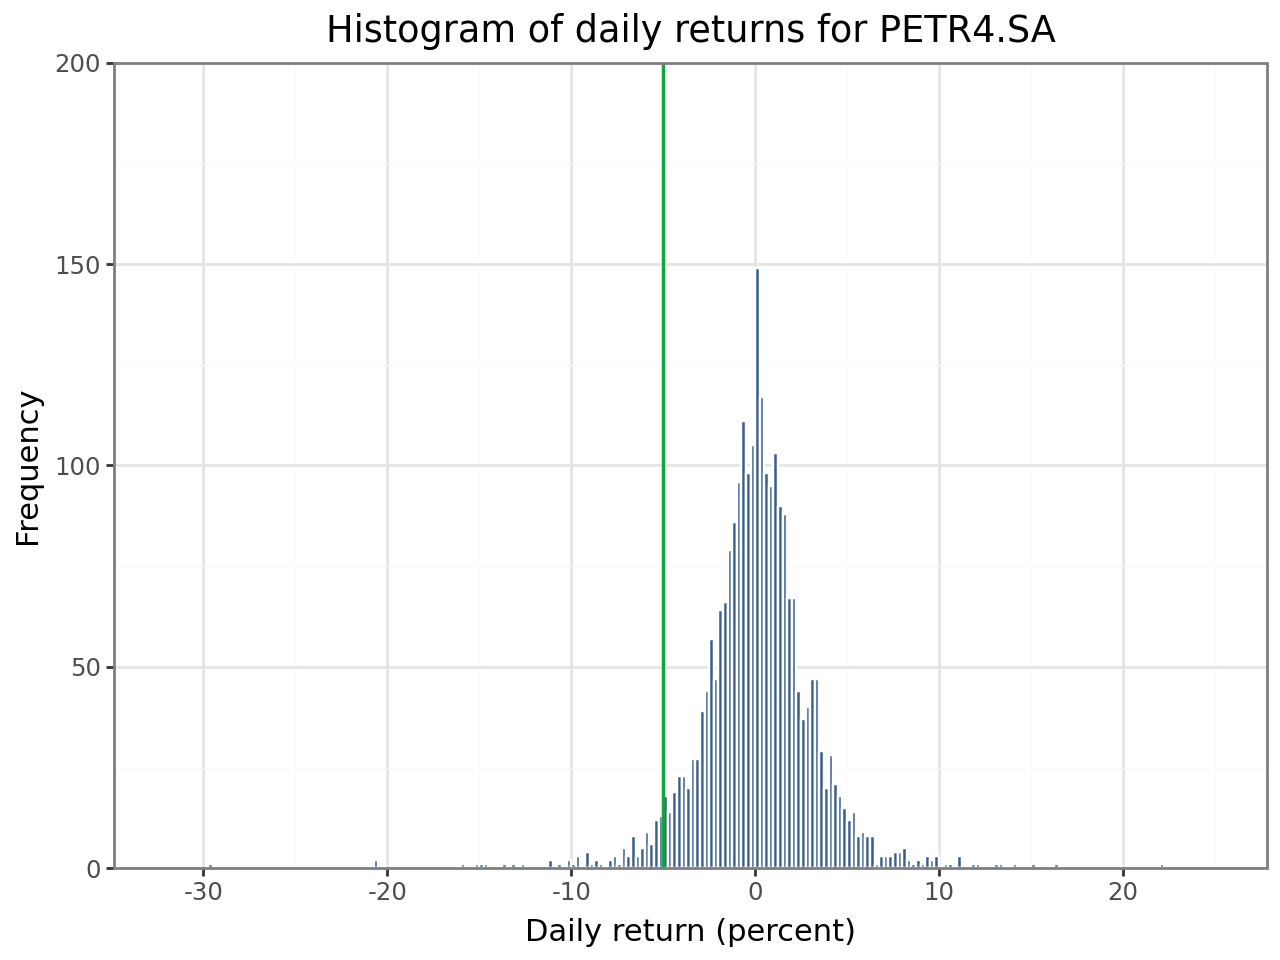

In [27]:
# Create histogram of daily returns
ggplot(petr4_df, aes("pct_return")) + geom_histogram(
    binwidth=0.25, color="white", fill=color[0], boundary=0, closed="left",
) + geom_vline(xintercept=-5, size=0.7, color=color[1]) + labs(
    x="Daily return (percent)", y="Frequency", title="Histogram of daily returns for PETR4.SA"
) + coord_cartesian(
    xlim=[-32, 25], ylim=[0, 200]
) + scale_y_continuous(
    expand=[0, 0]
) + geom_segment(
    aes(x=-6, y=220, xend=-5, yend=220)
) + annotate(
    "text", x=-8, y=220, label="5% loss", size=12
) + theme_bw()

We can notice a significant amount of observations below the 5% threshold. We can count the number of days that `PETR4.SA` closed at such low losses.

In [28]:
days_below_5pct = len(petr4_df.loc[petr4_df["pct_return"] <= -5, :])

days_below_5pct_proport = (days_below_5pct / petr4_df.shape[0]) * 100
print(f"There were {days_below_5pct} days in which the stock lost 5% or more. \nThis represents {days_below_5pct_proport:.2f}% of the total days ({petr4_df.shape[0]}).")

There were 97 days in which the stock lost 5% or more. 
This represents 3.90% of the total days (2490).


Now, for a total of 2490 days, we have noticed **97** days with losses below 5%, representing nearly **4%** of the total number of observations. 

## 3. Repeated samples, standard error ##
Considering the question "What *could* have been observed?", we can use **repeated samples** to make inferences about our dataset. That is, we can learn the distribution of each sample, get its estimate and observe the sampling distribution. Our most important goal here is to get its standard deviation, that is, how much *spread* we can observe across repeated samples. Remember that the standard deviation of the sampling distribution is called the **standard error**. 
We can now peform a simulation to exemplify the exercise. Our statistic of interest is the proportin of days with 5% of larger losses - in our case, it is **3.9%**. If we consider these 10 years of data our entire population, we already know the true value. We will ignore this fact and consider that the entire population encompasses a wider timespan.

In [29]:
# Remove NaN values from `pct_return` column
pct_return_no_na = petr4_df["pct_return"].dropna()

In [30]:
pct_return_no_na.describe()

count    2489.000000
mean        0.125630
std         3.110939
min       -29.697763
25%        -1.350565
50%         0.131601
75%         1.666044
max        22.222242
Name: pct_return, dtype: float64

Using a simple random sampling, we can now create samples based on the assumption that our data comprises only a 4 year period. Considering that each year has around 250 working days, we can use `10000` as our sample size.

In [31]:
def create_samples(vector, n_samples, n_obs):
    samples_pctloss = [None] * (n_samples + 1) # Create a list to store the samples
    for i in range(n_samples + 1):
        single_sample = np.random.choice(vector, size=n_obs, replace=True) # Create a single sample
        samples_pctloss[i] = sum(single_sample <= -5) / n_obs * 100 # Calculate the proportion of days with losses greater than 5%
    return samples_pctloss


Now, we can generate samples for 1000 and 500 observations. It is important to mention that, in our case, we are ignoring any dependence from a given value to the previous observations. That is, we are destroying the time-series component of our dataset for the purpose of understanding the process of generalizing from data.

In [39]:
np.random.seed = 123
n_obs_1000 = create_samples(pct_return_no_na, 10000, 1000)
n_obs_500 = create_samples(pct_return_no_na, 10000, 500)

In [40]:
n_obs_df = pd.DataFrame({"n_obs_500": n_obs_500, "n_obs_1000": n_obs_1000})

In [41]:
n_obs_df

,n_obs_500,n_obs_1000
0,3.6,3.6
1,3.0,3.5
2,3.8,3.7
3,4.6,4.1
4,3.0,4.6
...,...,...
9996,2.6,4.5
9997,5.2,5.0
9998,3.8,4.0
9999,4.2,4.0


In [42]:
n_obs_df["n_obs_500"] = n_obs_df["n_obs_500"]
n_obs_df["n_obs_1000"] = n_obs_df["n_obs_1000"]
n_obs_df.to_csv(f"{data_out}n_obs_df_output.csv", index=False, sep=",")

In [43]:
n_obs_df.describe()

,n_obs_500,n_obs_1000
count,10001.000000,10001.000000
mean,3.901730,3.896100
std,0.874692,0.612641
min,1.200000,2.000000
25%,3.200000,3.500000
50%,3.800000,3.900000
75%,4.400000,4.300000
max,8.000000,6.300000


The result is a DataFrame containing the percentage points of `pct_return` at a 5%+ loss. 
We can now calculate the margin of error and use it to find the confidence interval for the mean of our dataset with 1000 observations. A few comments:
1. Margin of Error Calculation
- `norm.ppf(0.975)` calculates the **z-score** (or the number of standard deviations from the mean) corresponding to the 97.5th percentile of the standard normal distribution. We use `0.975` for a 95% CI as the normal distribution is symmetric, and we want the area in the middle covering 95% of the distribution. As such, 2.5% is left on each side.
- `np.std(n_obs["n_obs_1000"])` calculates the **standard deviation** of the dataset.
- `/ np.sqrt(len(n_obs_df["n_obs_1000"]))` divides the standard deviation by the **squared root of the number of observations** in the dataset. We can then calculate the **standard error** of the mean.
- The entire expression calculates the margin of error for the 95% CI of the mean.

2. CI Calculation
- `np.mean(n_obs_df["n_obs_1000"])`: This calculates the mean of the dataset.
- `left = np.mean(n_obs_df["n_obs_1000"]) - error`: This subtracts the margin of error from the mean to find the lower bound of the 95% confidence interval.
- `right = np.mean(n_obs_df["n_obs_1000"]) + error`: This adds the margin of error to the mean to find the upper bound of the 95% confidence interval.

In [74]:
error = norm.ppf(0.975) * np.std(n_obs_df["n_obs_1000"]) / np.sqrt(len(n_obs_df["n_obs_1000"]))
left = np.mean(n_obs_df["n_obs_1000"]) - error
right = np.mean(n_obs_df["n_obs_1000"] + error)

Here, we get the mean of our sample and add and subtract the error for each variable.

In [75]:
ggplot(n_obs_df, aes(n_obs_1000[1:])) + geom_histogram(
    binwidth=0.1, color="white", fill=color[0], alpha=0.8, center=0.75, closed="left",
) + labs(x="Percent of days of losses of 5% or more", y="Frequency") + geom_vline(
    aes(xintercept=np.mean(pd.Series(n_obs_1000).dropna())), color=color[1], size=0.7
) + coord_cartesian(
    xlim=[2, 6], ylim=(0, 1000)
) + scale_x_continuous(
    expand=(0.1, 0.1), limits=(2, 6), breaks=seq(2, 6, 0.5)
) + scale_y_continuous(
    expand=(0.00, 0.00), limits=(0, 1000), breaks=seq(0, 1001, 250)
) + geom_segment(
    aes(x=4.3, y=900, xend=3.9, yend=900)
) + annotate(
    "text", x=4.5, y=900, label="Mean", size=12
) + theme_bw()

PlotnineError: 'Aesthetics must either be length one, or the same length as the data'

PlotnineError: 'Aesthetics must either be length one, or the same length as the data'

In [76]:
standard_error = np.std(n_obs_df["n_obs_1000"])
standard_error

np.float64(0.0)

Our standard error for the sample is 0.61%, which means that we can expect a value of 0.61% off from the mean across our samples, which was around 3.9%. We know this is the standard error because we calculated the standard deviation from the distribution over the fraction of 5%+ losses.

In [77]:
n_obs_df.describe()

,n_obs_500,n_obs_1000
count,10001.0,10001.0
mean,0.0,0.0
std,0.0,0.0
min,0.0,0.0
25%,0.0,0.0
50%,0.0,0.0
75%,0.0,0.0
max,0.0,0.0


**Sampling properties**:
- The average of the values in repeated samples is approximately **equal to its true value** (the value in the entire population, or general pattern, represented by our data).
    - This is called **unbiasedness**. 
- The sampling distribution is approximately normal.
    - **Asymptotic normality**
- The standard error is **smaller** in the **larger sample**.
    - **Root-n convergence**. The standard error is **inversely proportional** to the **square root of the sample size**.
    - So, in very large samples, the standard deviation can shrink to zero.

## Sampling distribution with different sample sizes ##
How does the spread of the distribution behave when using different sample sizes? We can now plot a histogram with samples of 500 days and compare its distribution with that of a sample of n=1000. First, we can plot the kernel density estimator.

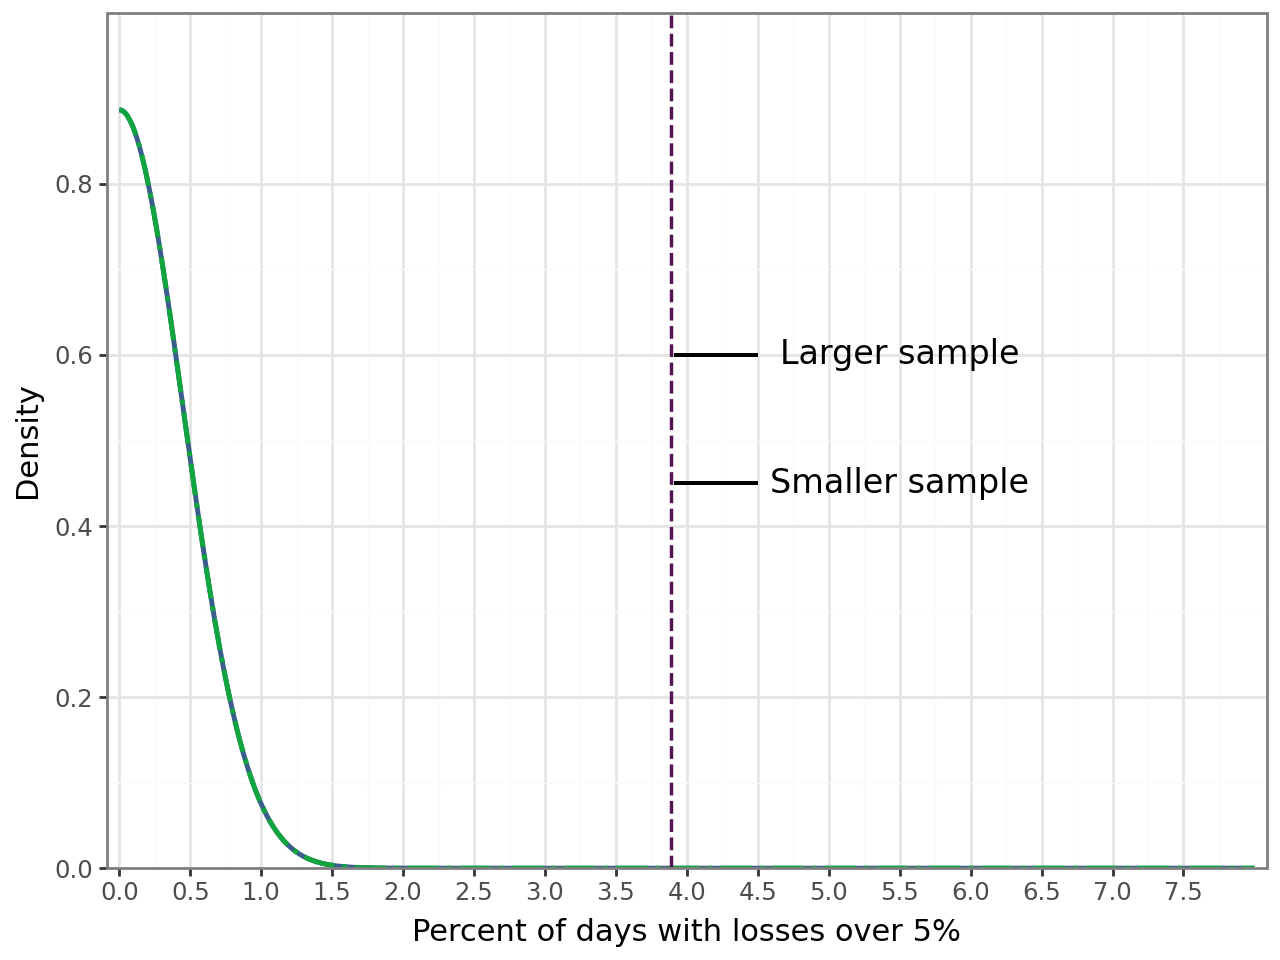

In [78]:
ggplot(n_obs_df) + stat_density(
    aes(x="n_obs_1000"), color=color[0], geom="line", bw=0.45, size=1
) + stat_density(
    aes("n_obs_500"), color=color[1], geom="line", bw=0.45, linetype="dashdot", size=1
) + labs(
    x="Percent of days with losses over 5%", y="Density"
)+ geom_vline(
    xintercept=3.89, color=color[2], size=0.7, linetype="dashed"
) + geom_segment(
    aes(x=3.91, y=0.6, xend=4.5, yend=.6),
    size=0.5
) + annotate(
    "text", x=5.5, y=0.6, label="Larger sample", size=12
) + geom_segment(
    aes(x=3.91, y=0.45, xend=4.5, yend=0.45), size=0.5
) + annotate(
    "text", x=5.5, y=0.45, label="Smaller sample", size=12
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(0, 8), breaks=seq(0, 8, 0.5)
) + scale_y_continuous(
    expand=(0.00, 0.00), limits=(0, 1), breaks=seq(0, 0.81, 0.2)
) + theme_bw() + theme(
    legend_position="none"
)

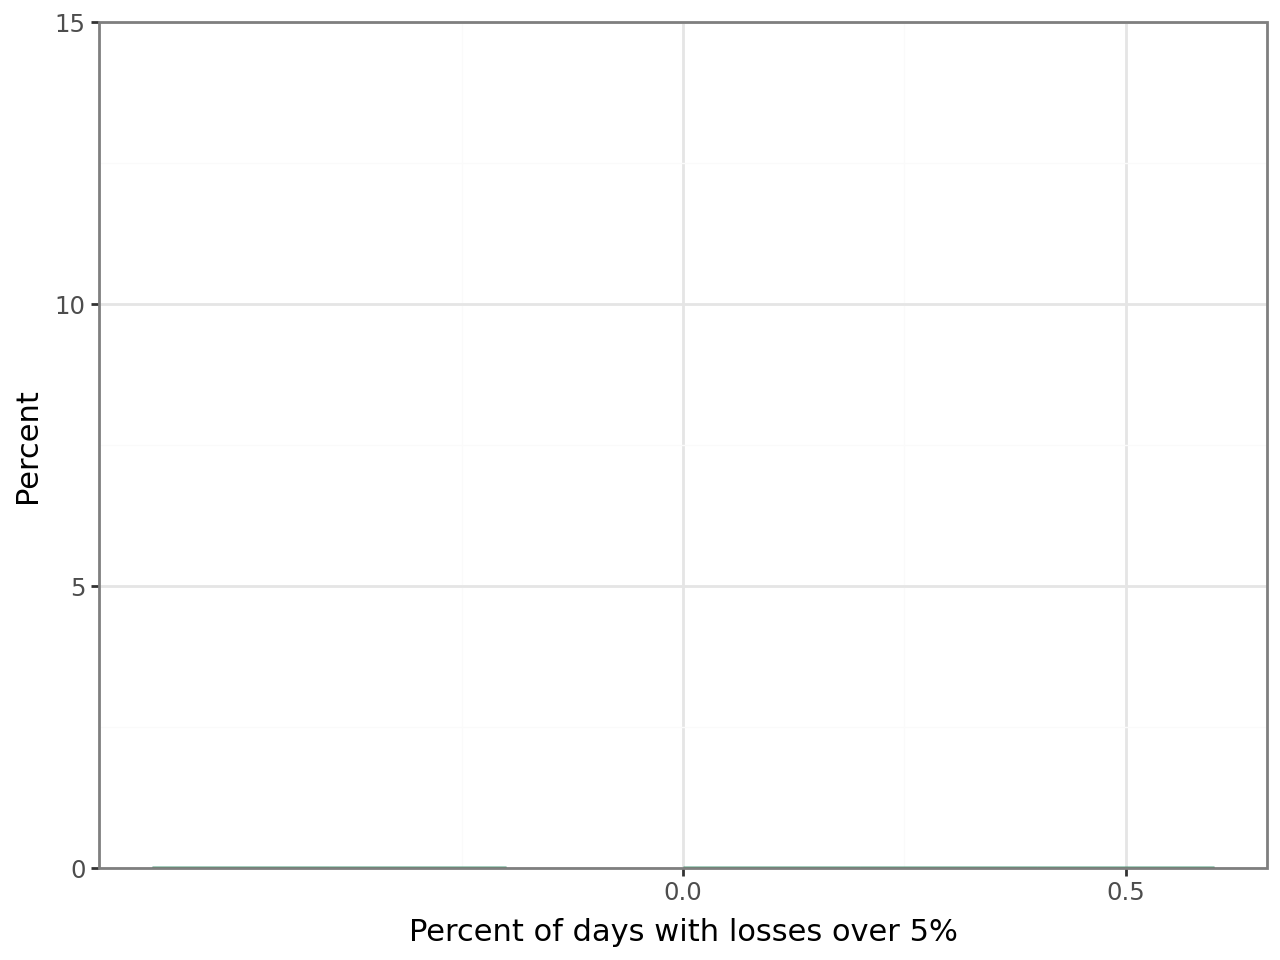

In [79]:
ggplot(n_obs_df) + geom_histogram(
    aes(x="n_obs_500", y="stat(count)/sum(stat(count))*100"),
    color=color[0],
    fill="blue",
    binwidth=0.2,
    center=0.5,
    size=0.7,
    alpha=0.4,
    closed="left"
) + geom_histogram(
    aes(x="n_obs_1000", y="stat(count)/sum(stat(count))*100"),
    color=color[1],
    fill="green",
    binwidth=0.2,
    center=0.5,
    size=0.7,
    alpha=0.1,
    closed="left"
) + ylab(
    "Percent"
) + xlab(
    "Percent of days with losses over 5%"
) + scale_x_continuous(
    breaks=seq(0, 8, 0.5)
) + scale_y_continuous(
    expand=(0.00, 0.00), limits=(0, 15), breaks=seq(0, 16, 5)
) + scale_color_manual(
    labels=("N=1000", "N=500"), name="", values=(color[1], color[0])
) + scale_alpha_identity() + scale_fill_identity() + theme_bw() + theme(
    legend_position="none"
)


Let's recap our tasks:
 - ~~Document the main features of the data~~ - 
- ~~Create daily percentage returns~~
- ~~Create a binary variable indicating large losses by choosing your own cutoff~~
## 4. Estimate the standard error of the estimated likelihood of large daily losses by bootsrap and using the SE formula. ##
We already got the standard error using bootstrap. Remember that the SE is squivalent to the standard deviation across the boostrap samples - we know it is **0.47**
Remember the **standard error** formula:

$SE_x = S /\sqrt{n}$

We can use our original data and obtain the standard error.

In [80]:
standard_error = sem(petr4_df["pct_return"] <= -5, nan_policy="omit")
print(f"The standard error for the proportion of days with 5%+ loss is {standard_error*100:.3f}%.")

The standard error for the proportion of days with 5%+ loss is 0.000%.


In [81]:
n_obs_df.describe()

,n_obs_500,n_obs_1000
count,10001.0,10001.0
mean,0.0,0.0
std,0.0,0.0
min,0.0,0.0
25%,0.0,0.0
50%,0.0,0.0
75%,0.0,0.0
max,0.0,0.0


Findings:
The observed decrease in the standard error (SE) from 0.85% with 500 observations to 0.61% with 1000 observations in our bootstrapping analysis is a reflection of a fundamental statistical principle: as the sample size increases, the precision of the estimate improves. This principle is rooted in the law of large numbers, which states that as the number of trials (or sample size) increases, the actual ratio of outcomes will converge on the theoretical, or expected, ratio of outcomes.

In the context of bootstrapping, each "observation" is actually a bootstrap sample, and the standard error measures the variability or spread of the bootstrapped estimates around their mean. A smaller standard error indicates that the bootstrapped estimates are more tightly clustered around the mean, suggesting a more precise estimate of the parameter being measured—in this case, the proportion of days with losses greater than 5%.

The decrease in SE with larger bootstrap samples (from 0.85% with 500 observations to 0.61% with 1000 observations) suggests that increasing the number of observations in each bootstrap sample leads to a more accurate and stable estimate of the proportion of interest. This is because larger samples are more likely to closely resemble the population from which they are drawn, capturing a more representative mix of the underlying variability and reducing the impact of random fluctuations or outliers.

In summary, the observed decrease in standard error with increased sample size in our bootstrapping analysis underscores the importance of sample size in statistical estimation. It demonstrates how larger samples can provide more reliable and precise estimates, a key consideration in statistical analysis and decision-making based on data.

## 5. Compare the two, and create 95% confidence intervals ##

We can now create our CI intervals. Going back to our task, our goal was:
- To estimate the CI for the proportion of days with large negative returns.
- We estimate that proportion from the data - we know that it is 3.9%.
Then, we estimate its standard error.

Following, we measure plus and minus two SE around this 3.9% value. We will get the 95% CI that tells us where to expect the majority of days with large negative returns in the general pattern represented by our data.

Now, we can estimate the SE by boostrap. We calculate the proportions of days with 5%+ loss in each sample. We save this value, go back to the original data and take another bootstramp sample, calculating this same proportion of losses and saving this value once again. We end up with a new data table, in which one observation stands for one bootstrap sample. 



In [82]:
# bootstrap samples
np.random.seed = 573164
M = 10000
results = np.zeros((M, 10)) # Create an array to store the results

We created an array based on the number of observations (10000) and columns (10). `np.zeros` returns a new array of given shape and type, filled with zeros.

In [83]:
# Iterate over the range of M, get a random sample of the data and calculate the proportion of days with losses greater than 5%
for i in range(1, M+1):
    btstrp_sample = np.random.choice(petr4_df["pct_return"], size=petr4_df.shape[0], replace=True)
    for j in range(1, 11):
        loss = pd.Series(btstrp_sample<=(-j)).apply(lambda x: float(x)) * 100
        results[i -1, j - 1] = np.mean(loss)

In [84]:
results = pd.DataFrame(
    results,
    columns=[
        "loss1",
        "loss2",
        "loss3",
        "loss4",
        "loss5",
        "loss6",
        "loss7",
        "loss8",
        "loss9",
        "loss10",
        ]
)

In [85]:
results

,loss1,loss2,loss3,loss4,loss5,loss6,loss7,loss8,loss9,loss10
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now, we want to know the estimated proportion of observations with 5%+ losses. Let's delve into the statistics of `loss5` before plotting the histogram.

In [86]:
results["loss5"].describe()

count    10000.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: loss5, dtype: float64

In [87]:
pd.DataFrame.from_dict(
    {
        "Statistics": [
            "Mean",
            "Standard deviation",
            "Min percentage",
            "Max percentage",
            "25% quantile",
            "Median",
            "75% quantile",
            "Number of observations",
        ],
        "Value": [
            results["loss5"].describe()["mean"],
            results["loss5"].describe()["std"],
            results["loss5"].min(),
            results["loss5"].max(),
            results["loss5"].quantile(0.25),
            results["loss5"].median(),
            results["loss5"].quantile(0.75),
            results["loss5"].describe()["count"],
        ],
    }
).round(2)

,Statistics,Value
0,Mean,0.0
1,Standard deviation,0.0
2,Min percentage,0.0
3,Max percentage,0.0
4,25% quantile,0.0
5,Median,0.0
6,75% quantile,0.0
7,Number of observations,10000.0


We can see how the mean is really close to the true value of our original population, `3.90%`. Out of 10000 iterations, we got values as low as 2.29% and as high as 5.38%. Because the mean is so close to the median, we can expect a normal distribution. Let's find out.

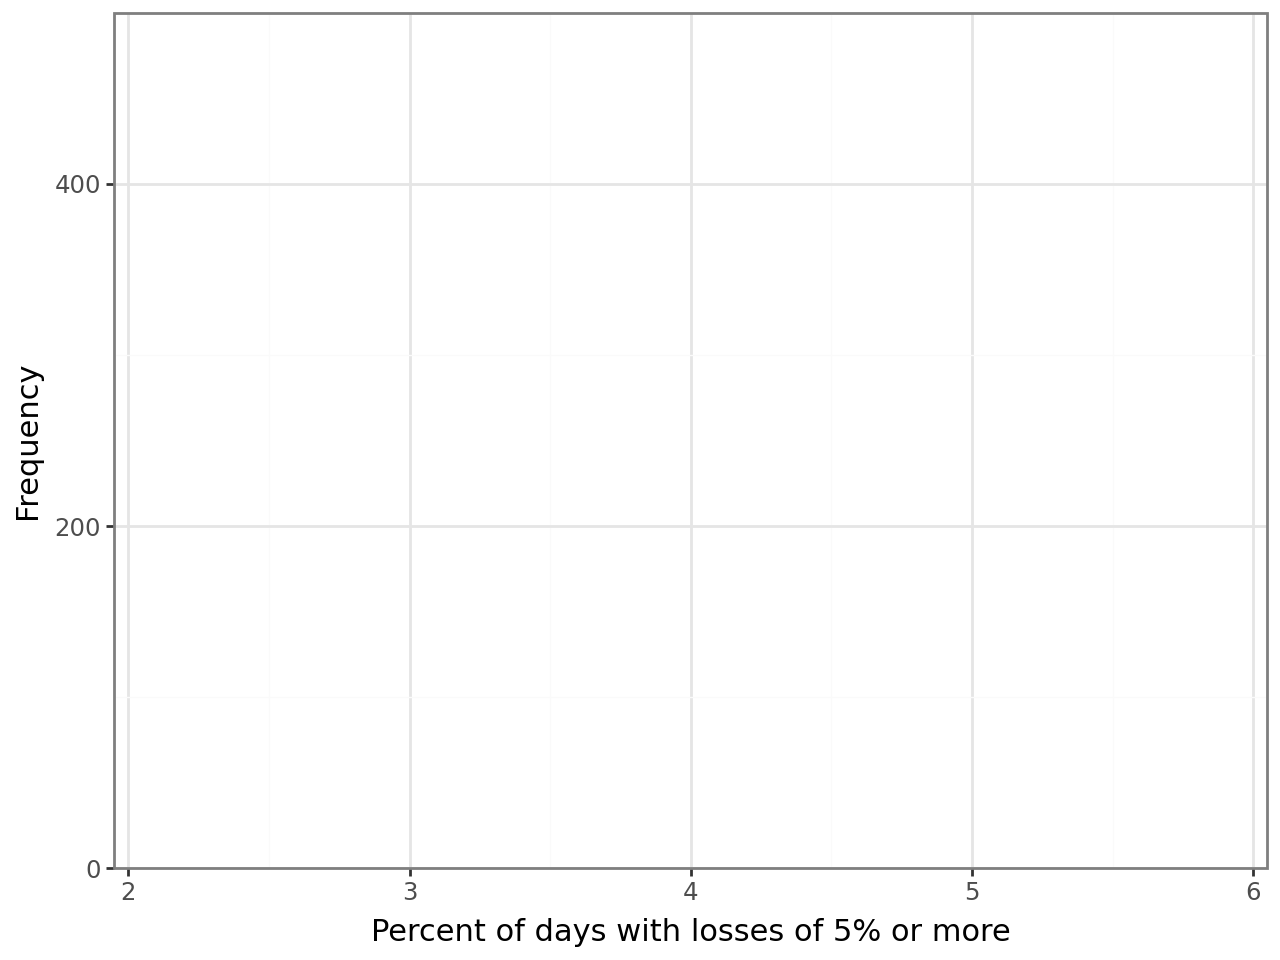

In [88]:
ggplot(results, aes("loss5")) + geom_histogram(
    fill=color[0], color="white", binwidth=0.04, boundary=0, closed="left"
) + scale_y_continuous(
    expand=(0, 0), limits=(0, 500), breaks=seq(0, 501, 200)
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(2, 6), breaks=seq(2, 6.1, 1)
) + labs(
    x="Percent of days with losses of 5% or more", y="Frequency"
) + theme_bw()

In [89]:
# Get the 95% confidence interval of `results["loss5"]`
conf_int = np.percentile(results["loss5"], [2.5, 97.5])
print(f"The 95% confidence interval for the proportion of days with losses greater than 5% is {conf_int}.")

The 95% confidence interval for the proportion of days with losses greater than 5% is [0. 0.].


We can check both SE, the formula and the bootstrapping technique, and we can observe that they are the same: 0.388%.



### Findings ###

With this, we can construct our confidence interval:
- The 95% CI is 3.9% +- 2 * 0.39. This means [3.13% and 4.69%]
- In the general pattern represented by the 11-year history of returns in our data, we can be **95% confident** that the chance of daily losses of more than 5% is **somewhere between 3.13% and 4.69%**.

## 6. Conclude by giving advice on how to use these results in future investments decisions.
Making choices about investments requires assessing risk, which means understanding the chances of incurring in major losses. In our experiment, we went far beyond a simple statistic - the mean value from a sample distribution - and tried to answer what *could* happen in similar scenarios if we did not know the full picture of our investment. This is usually the case and, after applying a sampling distribution and bootstrapping, we can better understand our risks.
When it comes to **Petrobras** (`PETR4.SA`) assets, the risk is quite **significant** - we are highly confident that we can expect a daily loss of a significant level - between 3 and 4.5 percent - so we would encourage the investor to take some precautionary measures when having such asset on their portfolio. Obviously, we did not estimate factors that could encourage investing on Petrobras, such as the level of returns or, even, the percentage of daily gains above a certain threshold. Every risky asset has its rewards. But we could consider advising investors to leverage such risk by acquiring safer assets as well. This would depend on further analyses.
